# SALT \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **ECCO**

In [6]:
from dask.distributed import Client

client = Client("tcp://10.32.16.248:38055")
client

Client Scheduler: tcp://10.32.16.248:38055 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
xr.set_options(display_style='text')

In [5]:
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/coords_wg.zarr')) #didn't upload wg region
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tns.zarr'))
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg.zarr'))
#ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_vel.zarr'))
ds = xr.merge([ds_tns, ds_slt, ds_vel])
ds

<xarray.Dataset>
Dimensions:                   (i: 95, i_g: 96, j: 50, j_g: 51, k: 50, k_l: 50, time: 288, time_snp: 287)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * time_snp                  (time_snp) datetime64[ns] 1992-02-01 ... 2015-12-01
  * k_l                       (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    SALT                      (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    SALT_snp                  (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA                     (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA_snp                 (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    dt                        (time) float32 dask.array<chunksize=(288,), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    salt_plume                (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_SLT          (k, time, j, i) float32 dask.array<chunksize=(50, 1, 50, 95), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    UVEL                      (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL                      (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL                      (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>

In [10]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [11]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [12]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

### Checking if `rhs` and `lhs` seem to match

In [15]:
rhs_vars = [dvar for dvar in ds_slt.data_vars
            if dvar != 'total_tendency_SLT_truth']
total_tendency_check = sum([ds_slt[dvar] for dvar in rhs_vars])
total_tendency_check

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float32, chunksize=(1, 50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

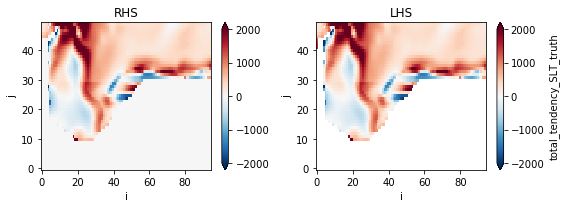

In [17]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].plot(ax=ax0, robust=True, vmax=2e3)
ax0.set_title('RHS')

ds.total_tendency_SLT_truth[1, 0].plot(ax=ax1, robust=True, vmax=2e3)
ax1.set_title('LHS')
plt.tight_layout();

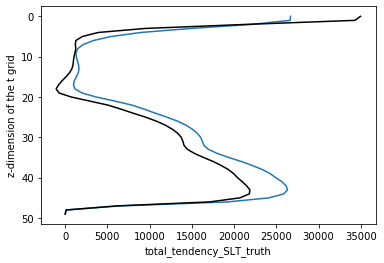

In [26]:
delta_salt = ds.SALT_snp.isel(time_snp=-1) - ds.SALT_snp.isel(time_snp=0)
total_time = (ds.time_snp[-1] - ds.time_snp[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC).isel(**lat_range_noface, **lon_range_noface)
((delta_salt * vol).sum(dim=['j', 'i'])/ total_time).plot(y='k', yincrease=False)
ds.total_tendency_SLT_truth.sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False, color='k')

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-SLT-truth} + R1 \end{equation*} </font>

In [30]:
ds.SALT_snp.max().values

array(35.81289, dtype=float32)

In [31]:
ds.SALT_snp.min().values

array(0., dtype=float32)

In [27]:
# define bins
delta_salt = 0.1
salt_bins = np.arange(32, 36, delta_salt)

In [48]:
# salt distribution in WG region
vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range_noface, **lon_range_noface)

salt_dist = histogram(ds.SALT_snp.rename('salt'), bins=[salt_bins],
                       weights=vol, dim=['i', 'j', 'k'])
salt_dist.load()

<xarray.DataArray 'histogram_salt' (time_snp: 287, salt_bin: 39)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 35.65 35.75 35.85

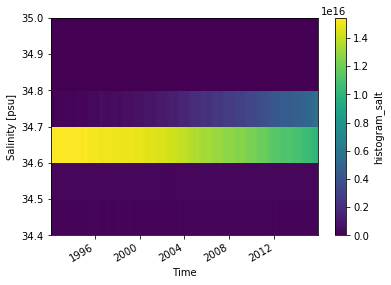

In [49]:
salt_dist.plot(x='time_snp'), plt.ylim(ymin=34.4, ymax=35);

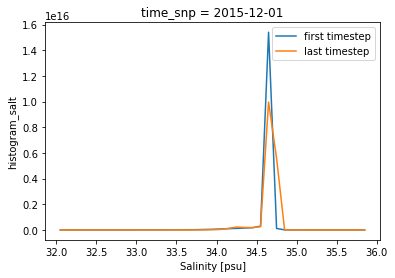

In [50]:
salt_dist[0].plot(label='first timestep')
salt_dist[-1].plot(label='last timestep')
plt.legend();

(34, 35.90000000000005)

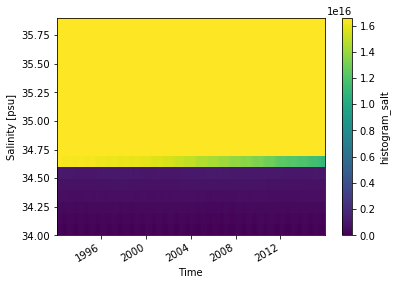

In [51]:
# cumulative volume
V = salt_dist.cumsum(dim='salt_bin')
V.transpose().plot()
plt.ylim(ymin=34)

In [52]:
V

<xarray.DataArray 'histogram_salt' (time_snp: 287, salt_bin: 39)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65797187e+16, 1.65797187e+16, 1.65797187e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65797187e+16, 1.65797187e+16, 1.65797187e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65797187e+16, 1.65797187e+16, 1.65797187e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65797187e+16, 1.65797187e+16, 1.65797187e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65797187e+16, 1.65797187e+16, 1.65797187e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.65797187e+16, 1.65797187e+16, 1.65797187e+16]])
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 35.65 35.75 35.85

In [53]:
delta_V = V.diff(dim='time_snp')
delta_V.coords['time'] = 'time_snp', ds.time[1:-1].values

In [54]:
delta_V

<xarray.DataArray 'histogram_salt' (time_snp: 286, salt_bin: 39)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 35.65 35.75 35.85
    time      (time_snp) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [55]:
ds.dt[1:-1]

<xarray.DataArray 'dt' (time: 286)>
dask.array<getitem, shape=(286,), dtype=float32, chunksize=(286,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

## $\frac{\partial \mathcal{V}}{\partial t}$

In [56]:
dVdt = delta_V.swap_dims({'time_snp': 'time'}) / ds.dt[1:-1]

(33, 35)

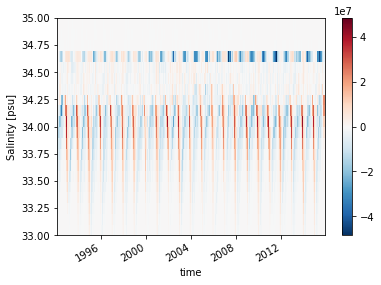

In [57]:
dVdt.plot(x='time')
plt.ylim(33, 35)

## $\Omega_{total}$

In [58]:
omega_total = - histogram(ds.SALT.rename('salt').chunk({'i':-1}), bins=[salt_bins],
                         weights=ds.total_tendency_SLT_truth,
                         dim=['i', 'j', 'k']) / delta_salt
omega_total.load()

<xarray.DataArray 'histogram_salt' (time: 288, salt_bin: 39)>
array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 35.65 35.75 35.85

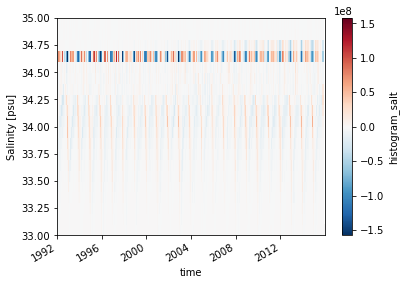

In [59]:
omega_total.plot(x='time')
plt.ylim(33, 35);

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

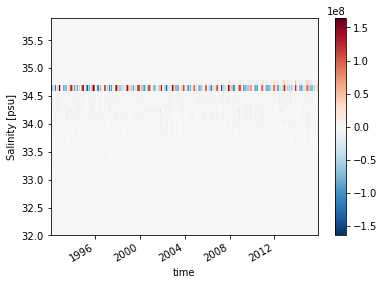

In [60]:
R1 = (dVdt.drop('time_snp').chunk({'time':1}) - omega_total[1:-1]).load()
R1.plot(x='time')

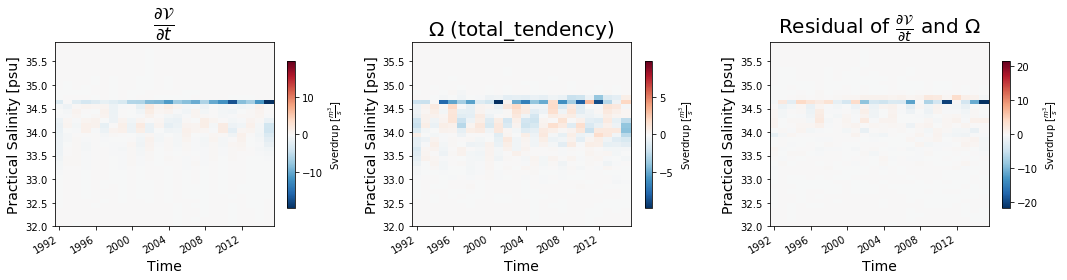

In [61]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel('Practical Salinity [psu]', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$', fontsize=24)

(omega_total[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel('Practical Salinity [psu]', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title('$\Omega$ (total_tendency)', fontsize=20)

(R1/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel('Practical Salinity [psu]', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$', fontsize=20)

plt.tight_layout();

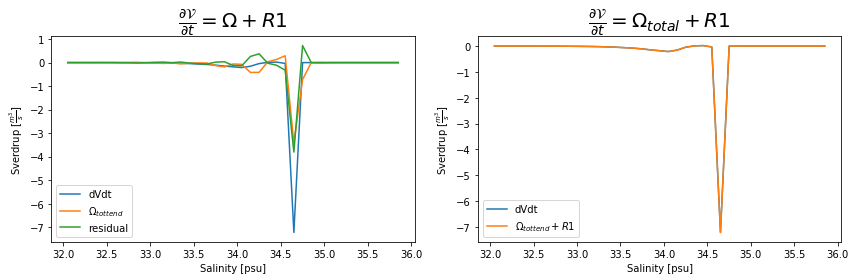

In [62]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel('Salinity [psu]')
ax0.legend()
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + R1$', fontsize=20)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.legend()
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$', fontsize=20)
plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [69]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(ds.SALT.rename('salt').chunk({'i':-1}), bins=[salt_bins],
                     weights=variable.fillna(0.), dim=['i', 'j', 'k'])
    return hist / delta_salt

In [64]:
all_tendencies = list(ds_slt)
all_tendencies

['conv_horiz_adv_flux_SLT',
 'conv_horiz_diff_flux_SLT',
 'conv_vert_adv_flux_SLT',
 'conv_vert_diff_flux_SLT',
 'salt_plume',
 'surface_flux_SLT',
 'total_tendency_SLT_truth']

In [70]:
all_dsets = xr.merge([histogram_func(ds_slt[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])
all_dsets

<xarray.Dataset>
Dimensions:                         (salt_bin: 39, time: 288)
Coordinates:
  * time                            (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * salt_bin                        (salt_bin) float64 32.05 32.15 ... 35.85
Data variables:
    OMEGA_conv_horiz_adv_flux_SLT   (time, salt_bin) float64 dask.array<chunksize=(1, 39), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_SLT  (time, salt_bin) float64 dask.array<chunksize=(1, 39), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_SLT    (time, salt_bin) float64 dask.array<chunksize=(1, 39), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_SLT   (time, salt_bin) float64 dask.array<chunksize=(1, 39), meta=np.ndarray>
    OMEGA_salt_plume                (time, salt_bin) float64 dask.array<chunksize=(1, 39), meta=np.ndarray>
    OMEGA_surface_flux_SLT          (time, salt_bin) float64 dask.array<chunksize=(1, 39), meta=np.ndarray>
    OMEGA_total_tendency_SLT_truth  (time, salt_bin) float64 dask.array<chunksize=(1, 39), meta=np.ndarray>

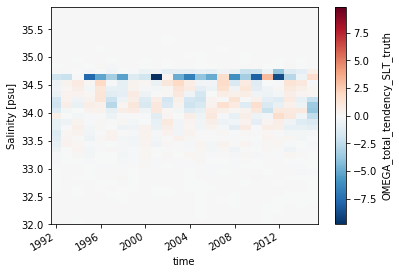

In [72]:
#checking to see if it looks the same as omega_total subplot above (and it does)
(-all_dsets.OMEGA_total_tendency_SLT_truth/1e6).resample(time='AS').mean(dim='time').plot(x='time')

In [74]:
omega_trans_rate = - (all_dsets.OMEGA_conv_horiz_diff_flux_SLT + 
                      all_dsets.OMEGA_conv_vert_diff_flux_SLT +
                      all_dsets.OMEGA_salt_plume + 
                      all_dsets.OMEGA_surface_flux_SLT)
omega_trans_rate.load()

<xarray.DataArray (time: 288, salt_bin: 39)>
array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
Coordinates:
  * time      (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 35.65 35.75 35.85

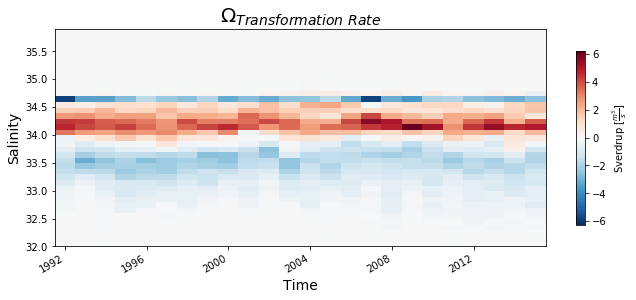

In [75]:
(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', figsize=(11,4), 
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Salinity', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'$\Omega_{Transformation\ Rate}$', fontsize=20);

### Checking to see if orig ds works
for tendency term

In [7]:
ds1 = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [8]:
ds_ll = faces_dataset_to_latlon(ds1)
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])

In [9]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds1 = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
ds_weddell = ds1.isel(**lon_range, **lat_range)
ds_weddell.nbytes/1e6

6091.898312

In [14]:
coords_weddell = coords.isel(**lat_range, **lon_range)

In [122]:
#calculating total tendency term for salt
salt_scaled = (ds.SALT_snp * (1 + (ds_weddell.ETAN_snp / coords_weddell.Depth))).diff('time_snp')

#forcing salt_scaled to have same timestamp as ds.dt by creating new data array called "salt_scaled"
salt_scaled = xr.DataArray(salt_scaled.data, dims=['time','k','j','i'], 
                            coords={'time': ds.dt[1:287].time.data})
salt_scaled
#units: g/kg (psu)

<xarray.DataArray 'sub-b64f34edf67336d22dcf79cae88801d6' (time: 286, k: 50, j: 50, i: 95)>
dask.array<sub, shape=(286, 50, 50, 95), dtype=float32, chunksize=(1, 50, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
Dimensions without coordinates: k, j, i

In [123]:
salt_tend = (salt_scaled / ds.dt[1:287])
#units: g/kg*s (psu/s)

In [125]:
volume = (coords_weddell.drF * coords_weddell.rA * coords_weddell.hFacC)
#day2seconds = (24*60*60)
totstend = salt_tend * volume

In [136]:
omega_total = - histogram(ds.SALT[1:-1].rename('salt').chunk({'i':-1}), bins=[salt_bins],
                         weights=totstend.chunk({'i':-1}),
                         dim=['i', 'j', 'k']) / delta_salt
omega_total.load()

<xarray.DataArray 'histogram_salt' (time: 286, salt_bin: 39)>
array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
Coordinates:
  * time      (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 35.65 35.75 35.85